# Speed Transformation

Speed is a calculated value derived from both time and distance.  Data transformations and algorithms are needed to give the end user a realistic representation of their moving speed.  The basic time transformation is handled in the "Time Transformation" notebook - this notebook transforms the data to give a constant one second interval between each data points.  This notebook applies the time series moving average algorithm to transform the speed data into sometime realistic and therefor useful for the end user.

## Speed Formula

Each data point represents exactly one second of activity.  The field `distance_ts` represents distance moved per second which can be considered the users speed in metres per second.  The field `speed_raw_ts` is simply `distance_ts * 3.6` which transforms speed from into kilometers per hour.

However the notebook shows that this simple approach to calculating speed is neither robust nor reliable.  The Garmin bike computer appears to introduce distance outliers into the data.  As a result speed calculations require the use of a time series algorithm.  This notebook used the time series weighted mean algorithm and shows that this fixes the data outliers and gives meaningful speed data. 

This notebook refers frequently to "raw speed".  Raw speed refers to taking the disance moved data as is from the Garmin computer and dividing distance by time for exactly one second intervals.  Due to anomolies in how the Garmin computer records data this will give misleading results.  As a result we need to move off "raw speed" and instead use a more complex (but more meaningful) rolling average speed.

Key-words:  time instance,  point in time,  zoom in, Python

## Approach
The standard web-sites, such as Garmin and Strava, only provide summary aggregated information.  What is different about this notebook is the ability to give tailored, specific, event driven information with full access to the Python powered modern data science tool-kits:
- **point in time analysis** - user can zoom in to any point of time within the activity period.  They can zero in on events of interest to them based on time.  The examples in this notebook are events relating to highest and second highest raw speeds.  On maps we are used to zooming in on the space dimension - point in time analysis is zooming using the time dimension.  This allows the user to drill into their performance for detailed information at those instances that can provide them with an edge.
- **variable time window** - the user can choose the amount of contextual data they view either side of the event's point in time.  They can select start and end time of a variable time window.  In the examples in the workbook these are 60 second time windows - but the time window can easily be customized.  By specifying the time window the user can get exactly the right amount of context to understand an event of interest.
- **choice of time series algorithms** - this workbook shows the application of a mean weighted time series algorithm.  Again this algorithm can be customized - or other data science algorothms applied.  The choise of algorithm opens up the events to analysis by the full data science and predictive analytics toolbox.
- **build on Python** - Python is the world's leading open source platform for data science and analytics.  This analysis uses Python Pandas which is extensively used for quantitive analysis in the financial services industry. 

The goal of this analysis is to give the athlete an edge by giving them better tools for understand their performance.  It allows the athlete to analyse specific events that occured during their training.  It allows the user to zoom into specific points in time and get the right amount of context and information.  It also puts the power of Python and the data science toolbox at their disposal 

## Setups

In [1]:
#Import Python Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [2]:
# Define name and path of data file
input_file = 'activity_speed_ts.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )
input_file_path = os.path.join(input_dir , input_file)
print ("Input file is (full path)  ", input_file_path)


Input file is (full path)   /opt/jupyter/data/csv/activity_speed_ts.csv


In [3]:
# Load data file into a Pandas data frame for inspection
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)
# clean-up columns
df.drop(['distance_diff', 'time_diff', 'speed_raw'], axis=1, inplace = True)
df = df[ ['speed_raw_ts','distance_ts', 'moving', 'breaks' ] ]
df.columns

Index(['speed_raw_ts', 'distance_ts', 'moving', 'breaks'], dtype='object')

In [4]:
# Define and set data source time zone
tz_source = 'UTC'
# Set timezone in our data frame
df = df.tz_localize( tz_source )

In [5]:
# Convert to local time zone - Dublin, Ireland
tz_local = timezone('Europe/Dublin')
df = df.tz_convert(tz_local  )
df.head()

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 07:25:51+01:00,0.0000,0.000,False,False
2015-09-13 07:25:52+01:00,16.6176,4.616,True,False
2015-09-13 07:25:53+01:00,16.6176,4.616,True,False
2015-09-13 07:25:54+01:00,16.6176,4.616,True,False
2015-09-13 07:25:55+01:00,16.6176,4.616,True,False


## Exploring the Imported Data Set


The data set for this notebook was captured with a Garmin bike computer during the Great Dublin Bike Ride in September 2015.  The overall data set includes GPS location, distance, heart rate, cycle cadence and elevation.  The data file contains over 16,000 data points relating to about 5 hours of activity.  

This spreadsheet is concerned with only one variable, raw speed - speed_raw_ts.  The is a non-robust definition of the raw speed based only on time travelled for each individual one second data point. The raw speed ( measured in km/hr) is calculated using the formula `distance_diff * 3.6`  : because time period is a constant one second.

A number of other variables are shown for illustration purposes.  If you examine the distance travelled per second (distance_diff), the shape of this plot maps exactly raw speed.  

Also shown are a few derived variables, not actaully used in this analysis.  
- `moving` : if the data point represents the cyclist actually moving then True, otherwise False
- `breaks` : Set to True if the using is at rest and taking a break from activity

A major focus of the next release of this application is to expose all the data variables captured from the Garmin.




/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


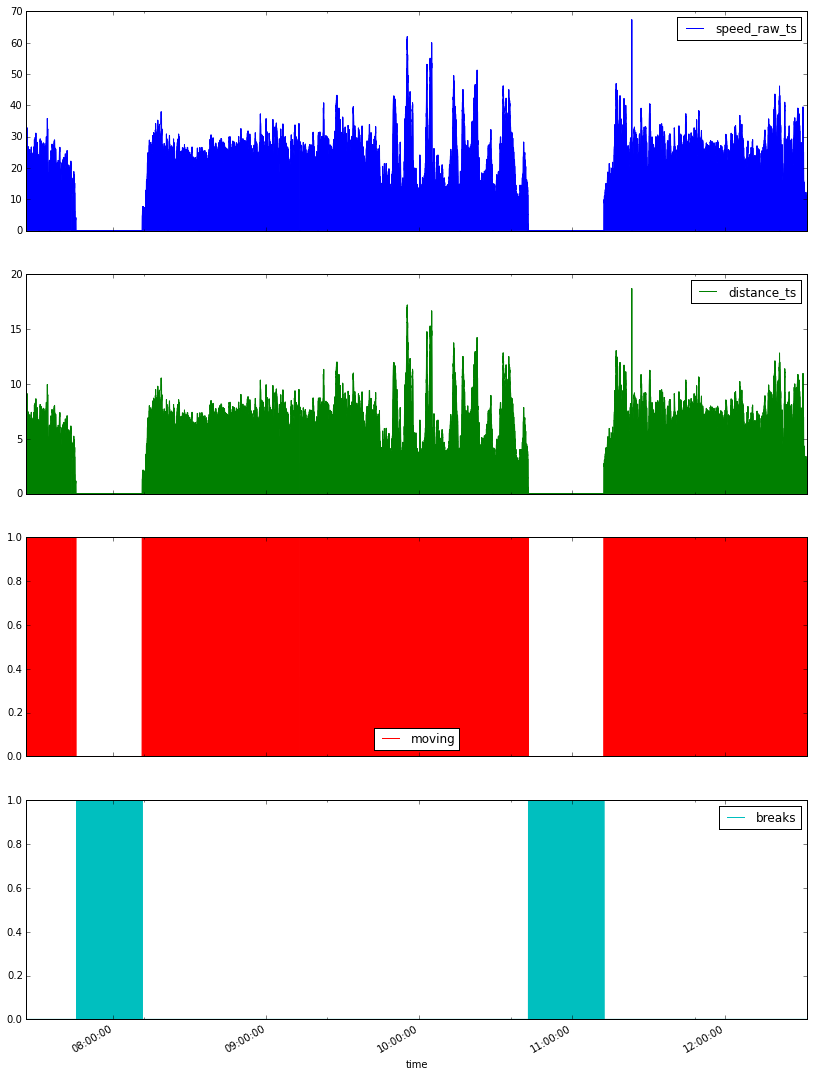

In [6]:
# plot all columns
# xlim=(datetime(2015,9,13,6,0,0),datetime(2015,9,13,12,0,0 )
_ = df.plot(kind = 'area',
    subplots=True, 
        figsize=(14, 20),
         )

In [7]:
#dir(matplotlib)
#matplotlib.__version__
# need to upgrade to 1.4
# need to use kind = 'area'

## Exploring the Raw Speed Data

The raw speed calculation gives a mis-leading representation of the rider's speed.  This is because of outliers in the data - the raw speed plot below points out a significant outlier that we will study further.  


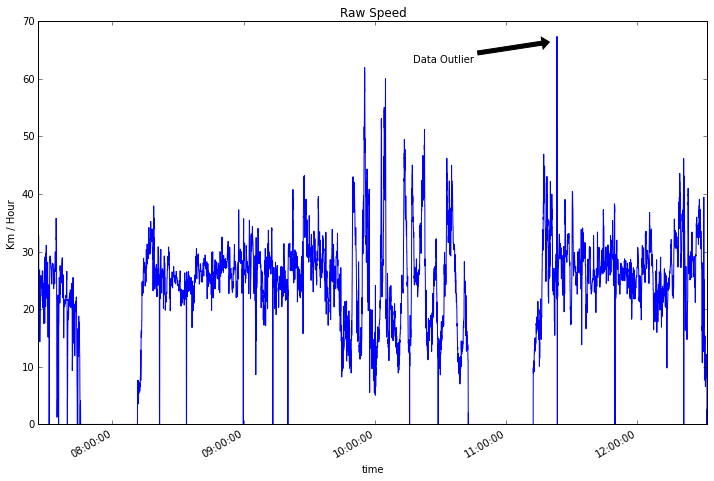

In [8]:
#Plot the speed data for all data points
plt.figure()
plt.title('Raw Speed')
plt.ylabel('Km / Hour')
plt.annotate('Data Outlier', xytext=(.56, .9) , xy=(.77, .95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05), xycoords='axes fraction',
            )


_ = df['speed_raw_ts'].plot( kind = 'line', figsize=(12,8),)

## Point in Time Analytics

### Define Time Window Function

In [9]:
# function to allow us to zoom into specific time windows
def get_window_range(dataframe, center_index, window):
    '''
    Return the index at the start and end of given time window for a specific data frame
    
    Input: 
        dataframe - name of dataframe
        center_index - time index in center of window
        window - time window, interval size in seconds
        
    Output:
        index_start - start index for time window
        index_end - end index
    
    '''
    interval = timedelta(seconds=window/2)
    index_start =  center_index - interval
    index_end = center_index + interval
    
    return index_start, index_end

### Event A -  Maximum Raw Speed
The first event we focus on is maximum raw speed of 67 km/hr
- Need to get exact time to second of max raw speed
- Store this time in the variable time_point_1
- Set up a 60 second time window with time_point_1 in centre
- Plot raw speed for this time window
- Calculate time series rolling average values 
- Compare raw speed and rolling average

#### Time of maximum raw speed

In [10]:
# find the row where raw speed is maximum
df[ df['speed_raw_ts'] > 60.0].sort_values(by = ['speed_raw_ts'], ascending = False)[0:1]

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 11:23:16+01:00,67.359375,18.710938,True,False


In [11]:
#store this time point in variable time_point_1
time_point_1 = \
            df[ df['speed_raw_ts'] > 60.0].sort_values(by = ['speed_raw_ts'], 
                        ascending = False).index[0:1][0]

#### Graph Raw Speed for 60 second time window

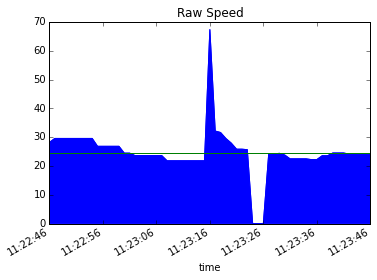

In [12]:
# define the width of the time window in seconds
time_window_seconds = 60

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(df, time_point_1, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()
max_raw_speed = df['speed_raw_ts'][ index_start: index_end ].max()

plt.figure()
plt.title('Raw Speed')
df['speed_raw_ts'][ index_start : index_end  ].plot(kind='area',figsize=(5.75,4), )
_ = plt.axhline(avg_speed, color='g')

In [13]:
print("The above diagram shows the data spike at {}".format(str(time_point_1)) )
print("The max speed of {:.1f} km/h is far in excess of the average speed of {:.1f} km/h"\
     .format( max_raw_speed, avg_speed ))

The above diagram shows the data spike at 2015-09-13 11:23:16+01:00
The max speed of 67.4 km/h is far in excess of the average speed of 24.6 km/h


#### Rolling Average Speed for 60 second time window centred on max raw speed

In [14]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 3

43.7


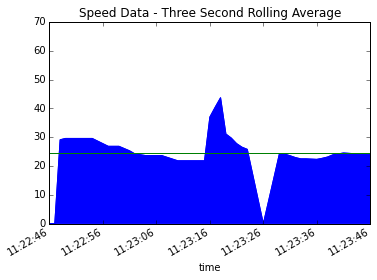

In [15]:
# here we apply the time series rolling average algorithm
# I experimented with various intervals , found 3 second interval worked best
plt.figure()
plt.ylim( (0,70) )
plt.title('Speed Data - Three Second Rolling Average')
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , window_size_seconds).plot(
                            figsize=(5.75,4),
                            kind='area',
                            )
_ = plt.axhline(avg_speed, color='g')

max_rolling_avg_speed = pd.rolling_mean( df['speed_raw_ts'][ index_start: index_end ],window_size_seconds ).max()
print( "{:.1f}".format( max_rolling_avg_speed ))

In [16]:
print("The max rolling average speed of {:.1f} km/h is close to the average speed of {:.1f} km/h"\
     .format( max_rolling_avg_speed, avg_speed ))
print("The rolling average algorithm has reduced data spike from {:.1f} km/h to {:.1f} km/h"\
     .format(max_raw_speed,max_rolling_avg_speed))


The max rolling average speed of 43.7 km/h is close to the average speed of 24.6 km/h
The rolling average algorithm has reduced data spike from 67.4 km/h to 43.7 km/h


#### Compare Raw Speed and Rolling Average Speed Calculations

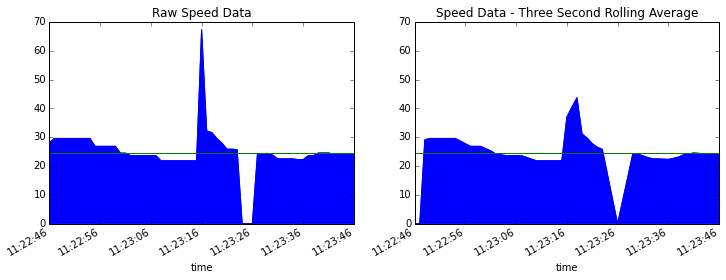

In [17]:
#generate two plots to compare raw speed with rolling average speed
plt.figure()
plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),kind='area',
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(kind='area',
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

The speed spike is the only data point that is changed dramatically by the rolling average algorithm - it has almost no impact on the other data points.

The smoothing algorithm gives the more realistic representation of the actual speed.

### Event B -  Second Highest Raw Speed
The second event we focus on is the second highest raw speed of 61.9 km/hr
- Need to get exact time to second of this raw speed
- Store this time in the variable time_point_2
- Set up a 40 second time window with time_point_2 in centre
- Plot raw speed for this time window
- Calculate time series rolling average values 
- Compare raw speed and rolling average

#### Time of second highest raw speed

In [18]:
# find the row where raw speed is second highest
df[ df['speed_raw_ts'] > 60.0].sort_values(by = ['speed_raw_ts'], ascending = False)[1:2]

,speed_raw_ts,distance_ts,moving,breaks
time,,,,
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False


In [19]:
#store this time point in variable time_point_2
time_point_2 = \
            df[ df['speed_raw_ts'] > 60.0].sort_values(by = ['speed_raw_ts'], 
                        ascending = False).index.tolist()[1:2][0]

#### Graph Raw Speed for 40 second time window

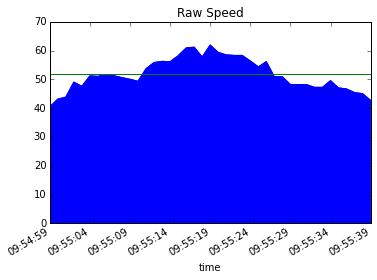

In [20]:
# define the width of the time window in seconds
time_window_seconds = 40

# Find the start and end time indexes for the window
index_start, index_end = get_window_range(df, time_point_2, time_window_seconds)

avg_speed = df['speed_raw_ts'][ index_start: index_end ].mean()
max_raw_speed = df['speed_raw_ts'][ index_start: index_end ].max()

plt.figure()
plt.title('Raw Speed')
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(5.75,4),kind='area',)
_ = plt.axhline(avg_speed, color='g')

In [21]:
print("The above diagram shows second highest speed at {}".format(str(time_point_2)) )
print("The plot shows that three of the data points exceed 60 km/hr")
print("The max speed of {:.1f} km/h compares with an average speed of {:.1f} km/h"\
     .format( max_raw_speed, avg_speed ))

The above diagram shows second highest speed at 2015-09-13 09:55:19+01:00
The plot shows that three of the data points exceed 60 km/hr
The max speed of 61.9 km/h compares with an average speed of 51.7 km/h


#### Rolling Average Speed for 40 second time window centred on second highest raw speed

61.1


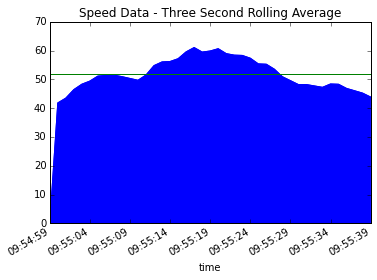

In [22]:
# here we apply the time series rolling average algorithm
# I experimented with various intervals , found 3 second interval worked best
plt.figure()
plt.ylim( (0,70) )
plt.title('Speed Data - Three Second Rolling Average')
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 2).plot(
                            figsize=(5.75,4),kind='area',
                            
                            )
_ = plt.axhline(avg_speed, color='g')

max_rolling_avg_speed = pd.rolling_mean( df['speed_raw_ts'][ index_start: index_end ],2 ).max()
print( "{:.1f}".format( max_rolling_avg_speed ))

In [23]:
print("The max rolling average speed of {:.1f} km/h is much closer to the average speed of {:.1f} km/h"\
     .format( max_rolling_avg_speed, avg_speed ))
print("The rolling average algorithm has reduced data spike from {:.1f} km/h to {:.1f} km/h"\
     .format(max_raw_speed,max_rolling_avg_speed))


The max rolling average speed of 61.1 km/h is much closer to the average speed of 51.7 km/h
The rolling average algorithm has reduced data spike from 61.9 km/h to 61.1 km/h


#### Compare Raw Speed and Rolling Average Speed Calculations

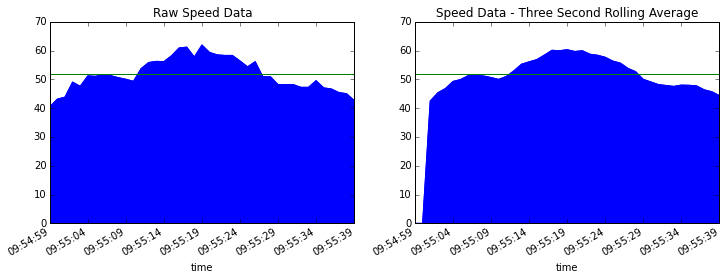

In [24]:
#generate two plots to compare raw speed with rolling average speed
plt.figure()
plt.subplot(1,2,1)
plt.ylim( (0,70) )
df['speed_raw_ts'][ index_start : index_end  ].plot(figsize=(12,4),kind='area',
                                                            )
_ = plt.axhline(avg_speed, color='g')
plt.title('Raw Speed Data')
plt.subplot(1,2,2)
plt.title('Speed Data - Three Second Rolling Average')
plt.ylim( (0,70) )
_ = pd.rolling_mean( df[ index_start : index_end ].speed_raw_ts , 3).plot(kind='area',
                            figsize=(12,4),
                            
                            )
_ = plt.axhline(avg_speed, color='g')

Smoothing function accurately smooths the speed data.  It makes no dramatic changes - just provides a subtle data smoothing.

## Rolling Average Speed

In [25]:
# having experimented with different values, 
# a smoothing window size of 3 seconds appears to provide best results
window_size_seconds = 3

In [26]:
# Save rolling average speed to the time series data set
df['speed_rollavg'] = pd.rolling_mean( df['speed_raw_ts'] , \
                                               window_size_seconds ).fillna(0.0)

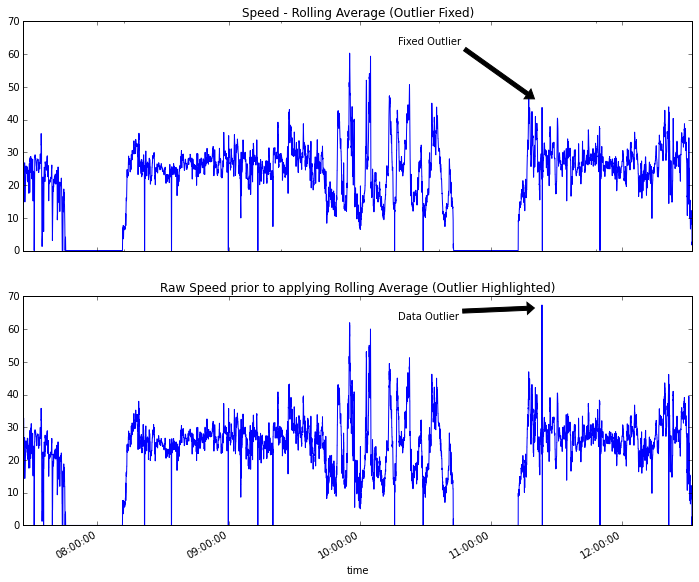

In [27]:
# Compare raw speed and rolling average speed
fig, axes = plt.subplots(nrows=2)

df['speed_rollavg'].plot(ax=axes[0],  sharex=True, figsize=(12,10)); 
axes[0].set_title('Speed - Rolling Average (Outlier Fixed)');
axes[0].annotate('Fixed Outlier', xytext=(.56, .9) , xy=(.77, .65), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05), xycoords='axes fraction',
            )

df['speed_raw_ts'].plot(ax=axes[1]); 
axes[1].set_title('Raw Speed prior to applying Rolling Average (Outlier Highlighted)');
_ = axes[1].annotate('Data Outlier', xytext=(.56, .9) , xy=(.77, .95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05), xycoords='axes fraction',
            )

In [28]:
# Top speed ordered by raw speed, giving rolling average value also
df[ df['speed_raw_ts'] > 60.0].sort_values(by = ['speed_raw_ts'], ascending = False)

,speed_raw_ts,distance_ts,moving,breaks,speed_rollavg
time,,,,,
2015-09-13 11:23:16+01:00,67.359375,18.710938,True,False,37.000781
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False,60.309375
2015-09-13 09:55:17+01:00,61.200000,17.000000,True,False,60.107813
2015-09-13 09:55:16+01:00,60.918750,16.921875,True,False,58.429688
2015-09-13 10:04:51+01:00,60.018750,16.671875,True,False,57.960938


In [29]:
# Top speed ordered by speed rolling average
df.sort_values(by = ['speed_rollavg'], ascending = False).head(5)

,speed_raw_ts,distance_ts,moving,breaks,speed_rollavg
time,,,,,
2015-09-13 09:55:19+01:00,61.945312,17.207031,True,False,60.309375
2015-09-13 09:55:17+01:00,61.200000,17.000000,True,False,60.107813
2015-09-13 09:55:18+01:00,57.782812,16.050781,True,False,59.967188
2015-09-13 09:55:21+01:00,58.528125,16.257812,True,False,59.948438
2015-09-13 09:55:20+01:00,59.371875,16.492188,True,False,59.700000
